# IMPORTING REQUIRED LIBRARIES

In [1]:
import collections as coll
import math
import pickle
import string

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
from nltk.corpus import cmudict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import nltk

nltk.download('cmudict')
nltk.download('stopwords')

style.use("ggplot")
cmuDictionary = None

[nltk_data] Downloading package cmudict to /home/bilal/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bilal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# DEFINING NECCESSARY FUNCTOINS TO LOAD FILES, SPLIT TEXT, AND COMPUTE FEATURES

In [2]:
def split_text(csv_file):
    MD_txt = ''
    Q_A_txt = ''
    QA_anly = ' '
    CEO_MD = ' '
    CEO_QA = ' '
    flag = False
    for index, row in csv_file.iterrows():
        if 'Question' in row['Name']:
            flag = True
        
        if flag == False:
            if row['Name'] == 'CEO' or row['Name'] == 'CFO' or row['Name'] == 'Employee':
                MD_txt += ' ' + row['Text']
                
        if flag == False:
            if row['Name'] == 'CEO':
                CEO_MD += ' ' + row['Text']
                
        
        if flag == True:
            if row['Name'] == 'CEO':
                CEO_QA += ' ' + row['Text']
                
        if flag == True:
            if row['Name'] == 'Analyst':
                QA_anly += ' ' + row['Text']
        
        if flag == True:
            if row['Name'] == 'CEO' or row['Name'] == 'CFO' or row['Name'] == 'Employee':
                Q_A_txt += ' ' + row['Text']
                
                
    return MD_txt, Q_A_txt, QA_anly, CEO_MD, CEO_QA
        

def read_file(doc_ID):
    import glob
    import pandas as pd
    filename = glob.glob('*/' + str(doc_ID))[0]
    csv_file = pd.read_csv(filename)
    return csv_file

def polarity(text):
    import pysentiment as ps
    lm = ps.LM()
    tokens = lm.tokenize(text)
    score = lm.get_score(tokens)
    return score['Polarity']

def subjectivity(text):
    import pysentiment as ps
    lm = ps.LM()
    tokens = lm.tokenize(text)
    score = lm.get_score(tokens)
    return score['Subjectivity']

def cleaning_text(text):
    import nltk
    from nltk.corpus import stopwords
    import re
    
    stopwords = nltk.corpus.stopwords.words('english')
    cleantext = re.sub( '\s+', ' ', text ).strip() # remove whitespace. https://www.w3schools.com/jsref/jsref_regexp_whitespace.asp
    cleantext = cleantext.lower() #lower case
    cleantext = re.sub( '[.:\',\-!;"()?]', "", cleantext).strip().split() # remove special characs
    cleantext = map(lambda x: x.lower(),cleantext)
    cleantext = [w for w in cleantext if w not in stopwords]
    cleantext = ' '.join(cleantext)
  
    return  cleantext

def padding(text):
    import nltk
    import re
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    stopwords = nltk.corpus.stopwords.words('english')
    text= re.findall('[A-z]+',text)
 
    content = [w for w in text if w.lower() in stopwords] # you can calculate %stopwords using "in"
    return round(float(len(content)) / len(text), 2)

# GENERATING CEO ALL CONFERENCE CALLS TEXT

In [ ]:
import pandas as pd
menu = pd.read_csv('menu_new.csv')
menu = menu.dropna(subset=['CEO_ID'])
CEO_ID = set(menu['CEO_ID'])
df = pd.DataFrame([])
idx = 0    
for CEO in CEO_ID:
    CEO_data = menu.loc[menu.CEO_ID==str(CEO)]
    CEO_text = ''
    for idex in CEO_data.index:
        Doc_ID = CEO_data.loc[idex, 'DocID']
        try:
            file = read_file(str(Doc_ID) + '.csv')
            MD_txt, Q_A_txt, QA_anly, CEO_MD, CEO_QA = split_text(file)
            CEO_lang = CEO_MD + CEO_QA
            CEO_text += CEO_lang
        except:
            pass
    df.loc[idx, 'CEO_ID'] = str(CEO)
    df.loc[idx, 'CEO_Text'] = CEO_text
    idx += 1
    print(idx)
    
df.to_csv('CEO_Text_final.csv')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146


# DEFINING LEXICAL FEATURES

In [3]:
def syllable_count_Manual(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
            if word.endswith("e"):
                count -= 1
    if count == 0:
        count += 1
    return count

def syllable_count(word):
    global cmuDictionary
    d = cmuDictionary
    try:
        syl = [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]][0]
    except:
        syl = syllable_count_Manual(word)
    return syl

# GIVES NUMBER OF SYLLABLES PER WORD
def Avg_Syllable_per_Word(text):
    from nltk.corpus import stopwords
    tokens = word_tokenize(text, language='english')
    st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
          "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']
    stop = stopwords.words('english') + st
    words = [word for word in tokens if word not in stop]
    syllabls = [syllable_count(word) for word in words]
    p = (" ".join(words))
    return sum(syllabls) / max(1, len(words))



def Avg_SentLenghtByCh(text):
    tokens = sent_tokenize(text)
    return np.average([len(token) for token in tokens])

# returns avg number of words in a sentence
def Avg_SentLenghtByWord(text):
    tokens = sent_tokenize(text)
    return np.average([len(token.split()) for token in tokens])

def Avg_Syllable_per_Word(text):
    tokens = word_tokenize(text, language='english')
    st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
          "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']
    stop = stopwords.words('english') + st
    words = [word for word in tokens if word not in stop]
    syllabls = [syllable_count(word) for word in words]
    p = (" ".join(words))
    return sum(syllabls) / max(1, len(words))

def CountFunctionalWords(text):
    functional_words = """a between in nor some upon
    about both including nothing somebody us
    above but inside of someone used
    after by into off something via
    all can is on such we
    although cos it once than what
    am do its one that whatever
    among down latter onto the when
    an each less opposite their where
    and either like or them whether
    another enough little our these which
    any every lots outside they while
    anybody everybody many over this who
    anyone everyone me own those whoever
    anything everything more past though whom
    are few most per through whose
    around following much plenty till will
    as for must plus to with
    at from my regarding toward within
    be have near same towards without
    because he need several under worth
    before her neither she unless would
    behind him no should unlike yes
    below i nobody since until you
    beside if none so up your
    """

    functional_words = functional_words.split()
    words = RemoveSpecialCHs(text)
    count = 0

    for i in text:
        if i in functional_words:
            count += 1

    return count / len(words)

# also returns Honore Measure R
def hapaxLegemena(text):
    words = RemoveSpecialCHs(text)
    V1 = 0
    # dictionary comprehension . har word kay against value 0 kardi
    freqs = {key: 0 for key in words}
    for word in words:
        freqs[word] += 1
    for word in freqs:
        if freqs[word] == 1:
            V1 += 1
    N = len(words)
    V = float(len(set(words)))
    R = 100 * math.log(N) / max(1, (1 - (V1 / V)))
    h = V1 / N
    return R, h

def hapaxDisLegemena(text):
    words = RemoveSpecialCHs(text)
    count = 0
    # Collections as coll Counter takes an iterable collapse duplicate and counts as
    # a dictionary how many equivelant items has been entered
    freqs = coll.Counter()
    freqs.update(words)
    for word in freqs:
        if freqs[word] == 2:
            count += 1

    h = count / float(len(words))
    S = count / float(len(set(words)))
    return S, h


def RemoveSpecialCHs(text):
    text = word_tokenize(text)
    st = [",", ".", "'", "!", '"', "#", "$", "%", "&", "(", ")", "*", "+", "-", ".", "/", ":", ";", "<", "=", '>', "?",
          "@", "[", "\\", "]", "^", "_", '`', "{", "|", "}", '~', '\t', '\n']

    words = [word for word in text if word not in st]
    return words

def BrunetsMeasureW(text):
    words = RemoveSpecialCHs(text)
    a = 0.17
    V = float(len(set(words)))
    N = len(words)
    B = (V - a) / (math.log(N))
    return B

def YulesCharacteristicK(text):
    words = RemoveSpecialCHs(text)
    N = len(words)
    freqs = coll.Counter()
    freqs.update(words)
    vi = coll.Counter()
    vi.update(freqs.values())
    M = sum([(value * value) * vi[value] for key, value in freqs.items()])
    K = 10000 * (M - N) / math.pow(N, 2)
    return K

def ShannonEntropy(text):
    words = RemoveSpecialCHs(text)
    lenght = len(words)
    freqs = coll.Counter()
    freqs.update(words)
    arr = np.array(list(freqs.values()))
    distribution = 1. * arr
    distribution /= max(1, lenght)
    import scipy as sc
    H = sc.stats.entropy(distribution, base=2)
    # H = sum([(i/lenght)*math.log(i/lenght,math.e) for i in freqs.values()])
    return H

def SimpsonsIndex(text):
    words = RemoveSpecialCHs(text)
    freqs = coll.Counter()
    freqs.update(words)
    N = len(words)
    n = sum([1.0 * i * (i - 1) for i in freqs.values()])
    D = 1 - (n / (N * (N - 1)))
    return D

def Total_words(text):
    return len(RemoveSpecialCHs(text))

# PREPARING TO USE LOUGHRAN MCDONALD DICTIONARY

In [4]:
#PLEASE MAKE SURE LM.xlsx IS PRESENT IN THE SAME DIRECTORY AS THIS FILE

import numpy as np
import pandas as pd
xls = pd.ExcelFile('LM.xlsx')

sheet_name = xls.sheet_names[1]
df = xls.parse(sheet_name=sheet_name, header=None)
df[sheet_name] = 1
df.columns = ['Word',sheet_name]
for sheet_name in xls.sheet_names[2:]:
    df_tmp = xls.parse(sheet_name=sheet_name, header=None)
    df_tmp[sheet_name] = 1
    df_tmp.columns = ['Word',sheet_name]
    df = pd.merge(df,df_tmp,on='Word',how='outer')
df.replace(np.nan,0).to_csv('LM.csv', index=False)

# A SUMMARY OF THE LOUGHRAN MCDONALD DICTIONARY (WORD LIST)

In [5]:
import numpy as np
import pandas as pd
LM_dict=pd.read_csv('LM.csv') # 2014 downloaded from LM website


# LM categories: Negative, Positive, Uncertainty, Litigious, Constraining, Superfluous, Interesting, Modal, Irregular Verb
pos_l =  list(map(lambda x: x.lower(),list(LM_dict.loc[(LM_dict['Positive']!=0)]['Word'])))
neg_l =  list(map(lambda x: x.lower(),list(LM_dict.loc[(LM_dict['Negative']!=0)]['Word'])))
unc_l =  list(map(lambda x: x.lower(),list(LM_dict.loc[(LM_dict['Uncertainty']!=0)]['Word'])))
lit_l =  list(map(lambda x: x.lower(),list(LM_dict.loc[(LM_dict['Litigious']!=0)]['Word'])))
cons_l = list(map(lambda x: x.lower(),list(LM_dict.loc[(LM_dict['Constraining']!=0)]['Word'])))

tot_dict = len(LM_dict) #81,321
classif_words = np.sum(len((pos_l))+len((neg_l))+len((unc_l))+len((lit_l))+len((cons_l)))

print('Total dict', tot_dict)
print('Classified Words', classif_words)
print('Unclassified Words', tot_dict - classif_words)
print(65*'*')
print('num of positive words', len(pos_l))
print('num of negative words', len(neg_l))
print('num of uncertainty words', len(unc_l))
print('num of litigious words', len(lit_l))
print('num of constraint words', len(cons_l))

Total dict 3876
Classified Words 4094
Unclassified Words -218
*****************************************************************
num of positive words 354
num of negative words 2355
num of uncertainty words 297
num of litigious words 904
num of constraint words 184


# SENTIMENT ANALYSIS

In [6]:
def LM_label_words(text):
    words = cleaning_text(text).split()
    n= len(words)
    LM_label_w= {'positive':[w.lower() for w in words if w in pos_l],
               'negative':[w.lower() for w in words if w in neg_l],
               'uncertainty':[w.lower() for w in words if w in unc_l],
               'litigious':[w.lower() for w in words if w in lit_l],
               'constraint':[w.lower() for w in words if w in cons_l]}
    return LM_label_w

def LM_label_pct(text):
    words = cleaning_text(text).split()
    n= len(words)
    LM_label_p= {'positive':float(len([w for w in words if w in pos_l]))/n,
               'negative':float(len([w for w in words if w in neg_l]))/n,
               'uncertainty':float(len([w for w in words if w in unc_l]))/n,
               'litigious':float(len([w for w in words if w in lit_l]))/n,
               'constraint':float(len([w for w in words if w in cons_l]))/n}
    return LM_label_p


def LM_label_pct_rel(text):
    words = cleaning_text(text).split()
    LM_label_p_rel= {'positive':float(len([w for w in words if w in pos_l])),
               'negative':float(len([w for w in words if w in neg_l])),
               'uncertainty':float(len([w for w in words if w in unc_l])),
               'litigious':float(len([w for w in words if w in lit_l])),
               'constraint':float(len([w for w in words if w in cons_l]))}
    n = np.sum(list(LM_label_p_rel.values()))
    LM_label_p_rel= {'positive':float(len([w for w in words if w in pos_l]))/n,
               'negative':float(len([w for w in words if w in neg_l]))/n,
               'uncertainty':float(len([w for w in words if w in unc_l]))/n,
               'litigious':float(len([w for w in words if w in lit_l]))/n,
               'constraint':float(len([w for w in words if w in cons_l]))/n}
    
    return LM_label_p_rel

# DEFINING WORD LIST FOR SINGULAR AND PLURAL PRONOUNS

In [7]:
singular_pronouns = ['I', 'me', 'you', 'she', 'her', 'him', 'it', 'he', 'myself', 'himself', 'herself', 'itself', 'yourself', 'my', 'your', 'his', 'its', 'mine', 'yours', 'hers']
plural_pronouns = ['we', 'us', 'they', 'them', 'these', 'those', 'ourselves', 'themselves', 'yourselves', 'our', 'their', 'ours', 'theirs']
singular_prnouns = set(singular_pronouns)
plural_pronouns = set(plural_pronouns)

# COMPUTING STOPWORDS AND POS_TAGS FOR Q/A AND MANAGEMENT DISCUSSION PARTS OF CONFERENCE CALLS

In [8]:
def remove_all(the_list, val):
    while val in the_list:
        the_list.remove(val)

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import numpy as np
from textstat.textstat import textstat
import datetime
import pandas as pd
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
import re
from nltk.util import ngrams
train_text = state_union.raw('2005-GWBush.txt')
custom_sent_tokenizer = PunktSentenceTokenizer(train_text)
stopwords_ = set(stopwords.words('english'))

menu = pd.read_csv('menu_new.csv')
file = pd.read_csv('CEO_Text_final.csv')
file = file.dropna(subset = ['CEO_Text'])
file = file.dropna(subset = ['CEO_ID'])
analyzer = SentimentIntensityAnalyzer()
outliers = ['#', '$', "''", '(', ')', ',', '.', ':', '``', "'", '`']
c = 0


for idx in file.index:
    CEO = file.loc[idx, 'CEO_ID']
    CEO_data = menu.loc[menu.CEO_ID==CEO]
    FullText = ''
    for idix in CEO_data.index:
        try:
            doc_id = str(CEO_data.loc[idix, 'DocID']) + '.csv'
            x_file = read_file(doc_id)
            MD_txt, Q_A_txt, QA_anly, CEO_MD, CEO_QA = split_text(x_file)
            FullText += CEO_MD + CEO_QA

        except:
            pass

    tokenized_FullText = custom_sent_tokenizer.tokenize(FullText)
    my_CEO = []

    for i in tokenized_FullText:
        words = nltk.word_tokenize(i)
        tagged = nltk.pos_tag(words)
        for each in tagged:
            my_CEO.append(each[1])
    for each in outliers:
        remove_all(my_CEO, each)
    tags_order = ' '.join(my_CEO)
    file.loc[idx, 'POS_tags'] = tags_order


    stopwords_FullText = []
    FullText_list = FullText.split(' ')
    for word in FullText_list:
        if word in stopwords_:
            stopwords_FullText.append(word)
    FullText_stopwords = ' '.join(stopwords_FullText)
    file.loc[idx, 'Stopwords'] = FullText_stopwords
    c += 1
    print(c)

        
file.to_csv('CEO_POS_Stopwords.csv')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# CEO ALL CONFERENCE CALLS LEXICAL FEATURE EXTRACTION

In [15]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import numpy as np
from textstat.textstat import textstat
import datetime
import pandas as pd
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
import re
from nltk.util import ngrams
train_text = state_union.raw('2005-GWBush.txt')
custom_sent_tokenizer = PunktSentenceTokenizer(train_text)

menu = pd.read_csv('CEO_Text_final.csv')
menu = menu.dropna(subset = ['CEO_Text'])
analyzer = SentimentIntensityAnalyzer()
outliers = ['#', '$', "''", '(', ')', ',', '.', ':', '``', "'", '`']
c = 0
for idx in menu.index:
    try:


        FullText = menu.loc[idx, 'CEO_Text']
        total_words = Total_words(FullText)

        sentences_Full = sent_tokenize(FullText)
        menu.loc[idx, 'Total_words'] = total_words
        menu.loc[idx, 'Num_syl'] = textstat.syllable_count(FullText) / total_words
        menu.loc[idx, 'Num_words'] = textstat.lexicon_count(FullText)/ total_words
        menu.loc[idx, 'Num_sent'] = textstat.sentence_count(FullText)/ total_words
        menu.loc[idx, 'Padding'] = padding(FullText)/ total_words
        menu.loc[idx, 'FE_idx'] = (100 - textstat.flesch_reading_ease(FullText)) / total_words
        menu.loc[idx, 'DC_idx'] = textstat.dale_chall_readability_score(FullText)/ total_words
        menu.loc[idx, 'DC_dif_words'] = textstat.difficult_words(FullText)/ total_words
        menu.loc[idx, 'Smog_Grade_idx'] = textstat.smog_index(FullText)/ total_words
        menu.loc[idx, 'FK_Grade_idx'] = textstat.flesch_kincaid_grade(FullText)/ total_words
        menu.loc[idx, 'CL_Grade_idx'] = textstat.coleman_liau_index(FullText)/ total_words
        menu.loc[idx, 'ARI_Grade_idx'] = textstat.automated_readability_index(FullText)/ total_words
        menu.loc[idx, 'LW_Grade_idx'] = textstat.linsear_write_formula(FullText)/ total_words
        menu.loc[idx, 'GFox_Grade_idx'] = textstat.gunning_fog(FullText)/ total_words

        menu.loc[idx, 'Polarity'] = polarity(FullText)/ total_words
        menu.loc[idx, 'Subjectivity'] = subjectivity(FullText)/ total_words

        # Percentage LM words per category in each text/obs as % Total Words
        menu.loc[idx, 'pos_perc_abs'] = LM_label_pct(FullText)['positive']/ total_words
        menu.loc[idx, 'neg_perc_abs'] = LM_label_pct(FullText)['negative']/ total_words
        menu.loc[idx, 'unc_perc_abs'] = LM_label_pct(FullText)['uncertainty']/ total_words
        menu.loc[idx, 'lit_perc_abs'] = LM_label_pct(FullText)['litigious']/ total_words
        menu.loc[idx, 'cons_perc_abs'] = LM_label_pct(FullText)['constraint']/ total_words
        # Percentage LM words per category in each text/obs as % sum of the overall LM words found across catefories:
        menu.loc[idx, 'pos_perc_rel'] = LM_label_pct_rel(FullText)['positive']/ total_words
        menu.loc[idx, 'neg_perc_rel'] = LM_label_pct_rel(FullText)['negative']/ total_words
        menu.loc[idx, 'unc_perc_rel'] = LM_label_pct_rel(FullText)['uncertainty']/ total_words
        menu.loc[idx, 'lit_perc_rel'] = LM_label_pct_rel(FullText)['litigious']/ total_words
        menu.loc[idx, 'cons_perc_rel'] = LM_label_pct_rel(FullText)['constraint']/ total_words




        list_neg=[]
        list_neu=[]
        list_pos=[]
        list_comp=[]
        for sentence in sentences_Full:
            vs = analyzer.polarity_scores(sentence)
            list_neg.append(vs['neg'])
            list_neu.append(vs['neu'])
            list_pos.append(vs['pos'])
            list_comp.append(vs['compound'])


        l_pos = filter(lambda x: x!=0, list_neg)
        menu.loc[idx, 'v_neg'] = np.average(np.array(list((filter(lambda x: x!=0, list_neg)))))
        menu.loc[idx, 'v_neu'] = np.average(np.array(list((filter(lambda x: x!=0, list_neu)))))
        menu.loc[idx, 'v_pos'] = np.average(np.array(list((filter(lambda x: x!=0, list_pos)))))
        menu.loc[idx, 'v_comp'] = np.average(np.array(list((filter(lambda x: x!=0, list_comp)))))

        singular_pronoun_count = 0
        plural_pronoun_count = 0
        for each in singular_pronouns:
            singular_pronoun_count += FullText.count(str(each))
            singular_pronoun_count /= total_words

        for each in plural_pronouns:
            plural_pronoun_count += FullText.count(str(each))
            plural_pronoun_count /= total_words

        menu.loc[idx, 'Singular_pronouns'] = singular_pronoun_count
        menu.loc[idx, 'Plural_pronouns'] = plural_pronoun_count


        HonoreMeasureR, hapax = hapaxLegemena(FullText)
        SichelesMeasureS, dihapax = hapaxDisLegemena(FullText)

        menu.loc[idx, 'HonoreMeasureR'] = HonoreMeasureR / total_words
        menu.loc[idx, 'hapax'] = hapax / total_words
        menu.loc[idx, 'SichelesMeasureS'] = SichelesMeasureS / total_words
        menu.loc[idx, 'dihapax'] = dihapax / total_words
        menu.loc[idx, 'Avg_Syllable_per_word'] = Avg_Syllable_per_Word(FullText) / total_words
        menu.loc[idx, 'Avg_SentLenghtByCh'] = Avg_SentLenghtByCh(FullText) / total_words


        menu.loc[idx, 'Avg_SentLenghtByWord'] = Avg_SentLenghtByWord(FullText) / total_words
        menu.loc[idx, 'Avg_Syllable_per_Word'] = Avg_Syllable_per_Word(FullText) / total_words
        menu.loc[idx, 'CountFunctionalWords'] = CountFunctionalWords(FullText) / total_words


        menu.loc[idx, 'BrunetsMeasureW'] = BrunetsMeasureW(FullText)/ total_words
        menu.loc[idx, 'YulesCharacteristicK'] = YulesCharacteristicK(FullText)/ total_words
        menu.loc[idx, 'ShannonEntropy'] = ShannonEntropy(FullText)/ total_words
        menu.loc[idx, 'SimpsonsIndex'] = ShannonEntropy(FullText)/ total_words


        c+= 1
        print(c)
    
    except:
        c += 1
        pass
    

menu.to_csv('CEO_lexical_features.csv')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
55
56
57
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
129
130
131
132
133
134
135
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
169
170
171
172
173
174
175
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
28

/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718


/home/bilal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/home/bilal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/bilal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/home/bilal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/bilal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972


# COMPUTING CEO RANKING (refer to the leadership report for understanding the computation of CEO Ranking)

In [6]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import datetime
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
import re
from nltk.util import ngrams
train_text = state_union.raw('2005-GWBush.txt')
custom_sent_tokenizer = PunktSentenceTokenizer(train_text)
df = pd.DataFrame([])

menu = pd.read_csv('menu_new.csv', parse_dates=['Date'])
menu = menu.dropna(subset = ['CEO_ID'])
menu = menu.dropna(subset = ['DocID'])
stock_data = pd.read_csv('sp500_adj_close_price_industry_adjusted.csv', index_col='date', parse_dates=['date'])
CEO_list = set(menu['CEO_ID'])


counter = 0
for CEO_ID in CEO_list:
    CEO_data = menu.loc[menu.CEO_ID==str(CEO_ID)]
    CEO_ID = str(CEO_ID)
        
    
    Company = str(CEO_ID[:CEO_ID.index('_')])
    Company = Company.upper()
    date_end = CEO_data['Date'].max()
    date_start = CEO_data['Date'].min()
    

    try:
        idx_begin = stock_data.index[stock_data.index.get_loc(date_start, method='bfill')]
        idx_end = stock_data.index[stock_data.index.get_loc(date_end , method='ffill')]
        start = stock_data.loc[idx_begin, Company]
        end = stock_data.loc[idx_end, Company]



        start_delay = (idx_begin - date_start).days

        end_delay = (date_end - idx_end).days

        tenure = (date_end - date_start).days / 365

        stock_price_time_corrected = (end / start) ** (1/ tenure)
        CEO_Ranking = (end / start)

        df.loc[counter, 'CEO_ID'] = CEO_ID
        df.loc[counter, 'Adj_stock_price_per'] = stock_price_time_corrected
        df.loc[counter, 'Actual_Start_Date'] = date_start
        df.loc[counter, 'Actual_End_Date'] = date_end
        df.loc[counter, 'Start_Delay'] = start_delay
        df.loc[counter, 'End_Delay'] = end_delay
        df.loc[counter, 'Tenure'] = tenure
        df.loc[counter, 'CEO_Ranking'] = CEO_Ranking


        print(counter)
        counter += 1
        
    except:
        counter += 1
        pass


df.to_csv('CEO_ranking_new.csv')

0
1
2
3
4
5
8
9
10
11
12
13
14
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
49
50
51
52
53
54
55
57
58
59
60
61
62
63
64
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
83
84
85
86
88
89
91
92
94
96
97
98
99
100
101
102
103
104
105
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
130
131
132
134
135
136
137
138
139
140
141
142
143
144
145
147
148
149
150
151
152
153
154
155
156
157
159
160
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
198
199
200
201
202
203
204
205
206
207
208
209
210
211
213
214
215
216
217
218
219
220
221
222
223
224
225
226
228
229
230
231
232
233
234
235
237
238
243
244
245
246
247
248
249
250
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
292
293
294
295
296
297
298
299
300
301
302


# USING FEATURES TO RUN THE CLASSIFICATION MODEL

# IMPORTING SIMON'S FEATURES

In [17]:
#FILES NEEDED: 1) CEO_Ranking_new) CEO_dna.json, 3) CEO_lexical_features
#ALTERNATIVE: SIMPLY LOAD CEO_DNA which contains all the features except tfidf scores

In [18]:
import json
import csv
import pandas as pd
import numpy as np

In [19]:
with open("CEO_dna.json") as file:
    data = json.load(file)

In [20]:
CEO_features = pd.read_csv('CEO_lexical_features.csv')

In [21]:
import pandas as pd
POS_stopword = pd.read_csv('CEO_POS_Stopwords.csv')

In [22]:
POS_stopword = POS_stopword.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])

In [23]:
CEO_data = pd.merge(left=POS_stopword, right=CEO_features, how= 'left', on='CEO_ID')

In [24]:
CEO_data = CEO_data.dropna()

In [36]:
rankings = pd.read_csv('CEO_ranking_new.csv')
rankings = rankings.dropna(subset = ['CEO_Ranking'])

In [26]:
df = pd.merge(left = rankings, right = CEO_data, how= 'left', on='CEO_ID')

In [27]:
data = pd.DataFrame(data)
data = data.T
data = data.reset_index()

In [28]:
data = data.rename(columns = {'index': 'CEO_ID'})

In [29]:
data_ = data[data.columns[1:]]

In [30]:
normalized_df=(data_-data_.mean())/data_.std()
normalized_df = normalized_df.dropna(axis='columns')

In [31]:
normalized_df["CEO_ID"] = data[data.columns[:1]]

In [32]:
df = pd.merge(left=df, right=normalized_df, how='left', on='CEO_ID')

In [33]:
df = df.dropna(subset = ['Stopwords'])
df = df.dropna(subset = ['POS_tags'])

In [34]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [9]:
#OPTIONAL- SIMPLY LOAD THIS FILE IF DO NOT WANT TO EXTRACT FEATURES FROM SCRACTH
#OTHERWISE DO NOT RUN THIS CELL
import pandas as pd
import numpy as np
df = pd.read_csv('CEO_DNA_new.csv')

In [10]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# SELECTING TOP 300 AND BOTTOM 300 CEOs

In [11]:
df_copy = df.copy()
n_largest = df_copy.nlargest(350, 'CEO_Ranking')
n_largest['label'] = 1
n_smallest = df_copy.nsmallest(350, 'CEO_Ranking')
n_smallest['label'] = 0

In [12]:
import pandas as pd
bigdata = pd.concat([n_largest, n_smallest])

In [34]:
text = bigdata[['POS_tags', 'Stopwords']]

# TD-IDF of word-grams for stopwords and POS Tags

In [13]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.svm import LinearSVC

In [16]:
#TDIDF FOR N-GRAMS OF STOPWORDS
#THESE PARAMETERS HAVE BEEN LEARNED THROUGH HYPER PARAMETER TUNING
corpus = text.Stopwords

vectorizer_stopword = TfidfVectorizer(analyzer='word', ngram_range=(1,4), min_df = 0.9, sublinear_tf=True)
X_stopword = vectorizer_stopword.fit_transform(corpus)

corpus = text.POS_tags
vectorizer_pos = TfidfVectorizer(analyzer='word', ngram_range=(1,4), min_df = 0.9, sublinear_tf=True)
X_pos = vectorizer_pos.fit_transform(corpus)

# NORMALIZING THE TFIDF SCORES ACROSS ALL CEOs

In [ ]:
X_stopword = X_stopword.toarray()
X_stopword= (X_stopword - X_stopword.mean(axis = 0)) / X_stopword.std(axis = 0)
X_pos = X_pos.toarray()
X_pos = ( X_pos - X_pos.mean(axis = 0)) / X_pos.std(axis = 0)
X_stopword = pd.DataFrame(X_stopword)
X_pos = pd.DataFrame(X_pos)
X_stopword.columns = vectorizer_stopword.get_feature_names()
X_pos.columns = vectorizer_pos.get_feature_names()
bigdata = bigdata.drop(columns = 'POS_tags')
bigdata = bigdata.drop(columns = 'Stopwords')

# Visualization POS-nGrams and Function Stopword nGrams (Visualizing the overlap of top 100 features

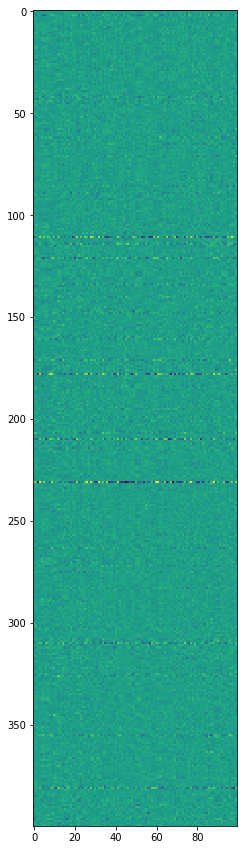

In [131]:
import matplotlib.pyplot as plt
X_stopword = np.vstack((X_stopword_largest, X_stopword_smallest))
idx = np.argsort(-X_stopword.sum(axis = 0))
plt.figure(figsize = (15, 15))
plt.imshow(X_stopword)

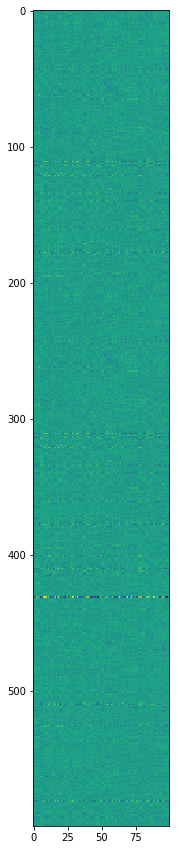

In [136]:
import matplotlib.pyplot as plt
X_pos = np.vstack((X_pos_largest, X_pos_smallest))
idx = np.argsort(-X_pos.sum(axis = 0))
plt.figure(figsize = (15, 15))
plt.imshow(X_pos)

# DEFINING UNIQUE FEATURE NAMES FOR N-GRAMS OF STOPWORDS AND POS-TAGS (important due to overlap)

In [22]:
pos_feature = []
for each in vectorizer_pos.get_feature_names():
    pos_feature.append((str(each) + '_QA'))

stopword_feature = []
for each in vectorizer_stopword.get_feature_names():
    stopword_feature.append((str(each) + '_SP'))

In [80]:
feature_names = stopword_feature + pos_feature + list(bigdata.columns)

In [81]:
X_style = bigdata.values
X = hstack([X_stopword, X_pos, X_style])

In [82]:
X = X.toarray()
X = pd.DataFrame(X)

In [83]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

In [84]:
X.columns = feature_names

In [85]:
X.shape

(700, 117559)

In [340]:
y_label = pd.DataFrame(y_label)

# MULTINOMIAL NAIVE BAYES

In [ ]:
from sklearn.model_selection import train_test_split
# Import train_test_split function

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.25)

#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y_label, test_size = 0.25)

# SUPPORT VECTOR CLASSIFIER

In [ ]:
clf = LinearSVC()
scores = cross_val_score(clf, train_X, train_y.values.reshape(-1), cv=10)
print('Accuracy of {}: {:.4f} (+/- {:.4f})'.format("CEO Language and Firm Performance", scores.mean(), scores.std() * 2))

clf.fit(train_X, train_y)
clf.score(val_X, val_y.values.reshape(-1))

# XGBoost Model

In [ ]:
import xgboost as xgb

model1 = xgb.XGBClassifier()
model2 = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.01, subsample=0.5)

train_model1 = model1.fit(train_X, train_y)
train_model2 = model2.fit(train_X, train_y)

#prediction and Classification Report
from sklearn.metrics import classification_report

pred1 = train_model1.predict(val_X)
pred2 = train_model2.predict(val_X)

print('Model 1 XGboost Report %r' % (classification_report(val_y, pred1)))
print('Model 2 XGboost Report %r' % (classification_report(val_y, pred2)))

#Let's use accuracy score
from sklearn.metrics import accuracy_score

print("Accuracy for model 1: %.2f" % (accuracy_score(val_y, pred1) * 100))
print("Accuracy for model 2: %.2f" % (accuracy_score(val_y, pred2) * 100))

# FEATURE IMPORTANCE USING PERMUTATION IMPORTANCE

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(clf, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, top = 50, feature_names =  list(X.columns))

# NUMBER OF WORDS VS ACCURACY (ALL OF THE FUNCTION ABOVE HAVE BEEN REDEFINED)

In [38]:
global result
result = []
words_count = [100, 250, 400, 500, 700, 900, 1000, 1300, 1700, 2000, 2500, 3200, 4000,4500, 5500, 7000, 9000, 10000]

In [15]:
def lexical_features(FullText, menu, idx):
    from nltk.corpus import stopwords
    import nltk
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    from nltk.tokenize import sent_tokenize, word_tokenize
    import pandas as pd
    import numpy as np
    from textstat.textstat import textstat
    import datetime
    import pandas as pd
    from nltk.corpus import state_union
    from nltk.tokenize import PunktSentenceTokenizer
    import re
    from nltk.util import ngrams
    train_text = state_union.raw('2005-GWBush.txt')
    custom_sent_tokenizer = PunktSentenceTokenizer(train_text)
    analyzer = SentimentIntensityAnalyzer()
    outliers = ['#', '$', "''", '(', ')', ',', '.', ':', '``', "'", '`']
   

    total_words = Total_words(FullText)

    sentences_Full = sent_tokenize(FullText)
    menu.loc[idx, 'Total_words'] = total_words
    menu.loc[idx, 'Num_syl'] = textstat.syllable_count(FullText) / total_words
    menu.loc[idx, 'Num_words'] = textstat.lexicon_count(FullText)/ total_words
    menu.loc[idx, 'Num_sent'] = textstat.sentence_count(FullText)/ total_words
    menu.loc[idx, 'Padding'] = padding(FullText)/ total_words
    menu.loc[idx, 'FE_idx'] = (100 - textstat.flesch_reading_ease(FullText)) / total_words
    menu.loc[idx, 'DC_idx'] = textstat.dale_chall_readability_score(FullText)/ total_words
    menu.loc[idx, 'DC_dif_words'] = textstat.difficult_words(FullText)/ total_words
    menu.loc[idx, 'Smog_Grade_idx'] = textstat.smog_index(FullText)/ total_words
    menu.loc[idx, 'FK_Grade_idx'] = textstat.flesch_kincaid_grade(FullText)/ total_words
    menu.loc[idx, 'CL_Grade_idx'] = textstat.coleman_liau_index(FullText)/ total_words
    menu.loc[idx, 'ARI_Grade_idx'] = textstat.automated_readability_index(FullText)/ total_words
    menu.loc[idx, 'LW_Grade_idx'] = textstat.linsear_write_formula(FullText)/ total_words
    menu.loc[idx, 'GFox_Grade_idx'] = textstat.gunning_fog(FullText)/ total_words

    menu.loc[idx, 'Polarity'] = polarity(FullText)/ total_words
    menu.loc[idx, 'Subjectivity'] = subjectivity(FullText)/ total_words

    # Percentage LM words per category in each text/obs as % Total Words
    menu.loc[idx, 'pos_perc_abs'] = LM_label_pct(FullText)['positive']/ total_words
    menu.loc[idx, 'neg_perc_abs'] = LM_label_pct(FullText)['negative']/ total_words
    menu.loc[idx, 'unc_perc_abs'] = LM_label_pct(FullText)['uncertainty']/ total_words
    menu.loc[idx, 'lit_perc_abs'] = LM_label_pct(FullText)['litigious']/ total_words
    menu.loc[idx, 'cons_perc_abs'] = LM_label_pct(FullText)['constraint']/ total_words
    # Percentage LM words per category in each text/obs as % sum of the overall LM words found across catefories:
    menu.loc[idx, 'pos_perc_rel'] = LM_label_pct_rel(FullText)['positive']/ total_words
    menu.loc[idx, 'neg_perc_rel'] = LM_label_pct_rel(FullText)['negative']/ total_words
    menu.loc[idx, 'unc_perc_rel'] = LM_label_pct_rel(FullText)['uncertainty']/ total_words
    menu.loc[idx, 'lit_perc_rel'] = LM_label_pct_rel(FullText)['litigious']/ total_words
    menu.loc[idx, 'cons_perc_rel'] = LM_label_pct_rel(FullText)['constraint']/ total_words




    list_neg=[]
    list_neu=[]
    list_pos=[]
    list_comp=[]
    for sentence in sentences_Full:
        vs = analyzer.polarity_scores(sentence)
        list_neg.append(vs['neg'])
        list_neu.append(vs['neu'])
        list_pos.append(vs['pos'])
        list_comp.append(vs['compound'])


    l_pos = filter(lambda x: x!=0, list_neg)
    menu.loc[idx, 'v_neg'] = np.average(np.array(list((filter(lambda x: x!=0, list_neg)))))
    menu.loc[idx, 'v_neu'] = np.average(np.array(list((filter(lambda x: x!=0, list_neu)))))
    menu.loc[idx, 'v_pos'] = np.average(np.array(list((filter(lambda x: x!=0, list_pos)))))
    menu.loc[idx, 'v_comp'] = np.average(np.array(list((filter(lambda x: x!=0, list_comp)))))

    singular_pronoun_count = 0
    plural_pronoun_count = 0
    for each in singular_pronouns:
        singular_pronoun_count += FullText.count(str(each))
        singular_pronoun_count /= total_words

    for each in plural_pronouns:
        plural_pronoun_count += FullText.count(str(each))
        plural_pronoun_count /= total_words

    menu.loc[idx, 'Singular_pronouns'] = singular_pronoun_count
    menu.loc[idx, 'Plural_pronouns'] = plural_pronoun_count


    HonoreMeasureR, hapax = hapaxLegemena(FullText)
    SichelesMeasureS, dihapax = hapaxDisLegemena(FullText)

    menu.loc[idx, 'HonoreMeasureR'] = HonoreMeasureR / total_words
    menu.loc[idx, 'hapax'] = hapax / total_words
    menu.loc[idx, 'SichelesMeasureS'] = SichelesMeasureS / total_words
    menu.loc[idx, 'dihapax'] = dihapax / total_words
    menu.loc[idx, 'Avg_SentLenghtByCh'] = Avg_SentLenghtByCh(FullText) / total_words


    menu.loc[idx, 'Avg_SentLenghtByWord'] = Avg_SentLenghtByWord(FullText) / total_words
    #menu.loc[idx, 'Avg_Syllable_per_Word'] = Avg_Syllable_per_Word(FullText) / total_words
    menu.loc[idx, 'CountFunctionalWords'] = CountFunctionalWords(FullText) / total_words


    menu.loc[idx, 'BrunetsMeasureW'] = BrunetsMeasureW(FullText)/ total_words
    menu.loc[idx, 'YulesCharacteristicK'] = YulesCharacteristicK(FullText)/ total_words
    menu.loc[idx, 'ShannonEntropy'] = ShannonEntropy(FullText)/ total_words
    menu.loc[idx, 'SimpsonsIndex'] = ShannonEntropy(FullText)/ total_words


    print('Lexical_done')

In [16]:
from nltk.corpus import stopwords
stopwords_ = set(stopwords.words('english'))

In [17]:
def POS_Stopwords(FullText, menu, idx):
    from nltk.corpus import stopwords
    outliers = ['#', '$', "''", '(', ')', ',', '.', ':', '``', "'", '`']
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    from nltk.tokenize import sent_tokenize, word_tokenize
    import pandas as pd
    import numpy as np
    from textstat.textstat import textstat
    import datetime
    import pandas as pd
    from nltk.corpus import state_union
    from nltk.tokenize import PunktSentenceTokenizer
    import re
    from nltk.util import ngrams
    train_text = state_union.raw('2005-GWBush.txt')
    custom_sent_tokenizer = PunktSentenceTokenizer(train_text)
    stopwords_ = set(stopwords.words('english'))
    
    tokenized_FullText = custom_sent_tokenizer.tokenize(FullText)
    my_CEO = []

    for i in tokenized_FullText:
        words = nltk.word_tokenize(i)
        tagged = nltk.pos_tag(words)
        for each in tagged:
            my_CEO.append(each[1])
    for each in outliers:
        remove_all(my_CEO, each)
    tags_order = ' '.join(my_CEO)
    menu.loc[idx, 'POS_tags'] = tags_order


    stopwords_FullText = []
    FullText_list = FullText.split(' ')
    for word in FullText_list:
        if word in stopwords_:
            stopwords_FullText.append(word)
    FullText_stopwords = ' '.join(stopwords_FullText)
    menu.loc[idx, 'Stopwords'] = FullText_stopwords
    print('POS_Done')

In [18]:
#INCLUDE STOPWORDS N-GRAMS
def tfidfVectorizer(tags, stopwords):
    #TDIDF FOR N-GRAMS OF STOPWORDS
    corpus = tags
    vectorizer_pos = TfidfVectorizer(analyzer='word', ngram_range=(1,4), min_df = 0.9, sublinear_tf=True)
    X_pos = vectorizer_pos.fit_transform(corpus)
    
    corpus = stopwords
    vectorizer_stopword = TfidfVectorizer(analyzer='word', ngram_range=(1,4), min_df = 0.9, sublinear_tf=True)
    X_stopword = vectorizer_stopword.fit_transform(corpus)
    print('tfidf Done')
    return X_pos, X_stopword
    

In [19]:
def normalize(X_pos, X_stopword):
    X_stopword = X_stopword.toarray()
    X_stopword= (X_stopword - X_stopword.mean(axis = 0)) / X_stopword.std(axis = 0)
    X_pos = X_pos.toarray()
    X_pos = ( X_pos - X_pos.mean(axis = 0)) / X_pos.std(axis = 0)
    X_stopword = pd.DataFrame(X_stopword)
    X_pos = pd.DataFrame(X_pos)
    print('Normalize Done')
    return X_pos, X_stopword

In [20]:
def stack(X_stopword, X_pos, menu):
    bigdata = menu
    
    X_style = bigdata.values
    X = hstack([X_pos,X_stopword, X_style])
    
    X = X.toarray()
    X = pd.DataFrame(X)
    print('stack Done')
    return X
    

In [21]:
def run_model(X, y_label, count):
    from sklearn.model_selection import train_test_split
    # Import train_test_split function

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.20, stratify = y_label, random_state = 100)

    #Import Gaussian Naive Bayes model
    from sklearn.naive_bayes import GaussianNB

    #Create a Gaussian Classifier
    gnb = GaussianNB()

    #Train the model using the training sets
    gnb.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = gnb.predict(X_test)

    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics

    # Model Accuracy, how often is the classifier correct?
    NaiveBayes = metrics.accuracy_score(y_test, y_pred)
    
    clf = LinearSVC()
    scores = cross_val_score(clf, X_train, y_train, cv =10)
    SVC_1 = scores.mean()
    clf.fit(X_train, y_train)
    SVC_2 = clf.score(X_test, y_test)
   
    
    print('Model Run')
    result.append((count, len(y_label), NaiveBayes, SVC_1, SVC_2))

In [22]:
FullText_list = list(bigdata['CEO_Text_x'])
FullText_ = []
for each in FullText_list:
    FullText_.append(each.split(' '))
print(len(FullText_))

700


In [24]:
POS_list = list(bigdata['POS_tags'])
POS_ = []
for each in POS_list:
    POS_.append(each.split(" "))
print(len(POS_))

700


In [23]:
stopwords_list = list(bigdata['Stopwords'])
sp = []
for each in stopwords_list:
    sp.append(each.split(' '))
print(len(sp))

700


In [46]:
y = [1] * 350 + [0] * 350

In [47]:
from nltk.tokenize import word_tokenize
counter = 0
for count in words_count:
    y_label = []
    idx = 0
    pos = []
    Text = []
    stopwords = []
    menu = pd.DataFrame([])
    for i in range(len(FullText_)):
        if len(FullText_[i]) >= count and len(sp[i]) >= count and len(POS_[i]) >=count:
            to_append1 = ' '.join(FullText_[i][:count])
            Text.append(to_append1)
            to_append2 = ' '.join(sp[i][:count])
            stopwords.append(to_append2)
            to_append3 = ' '.join(POS_[i][:count])
            pos.append(to_append3)
            y_label.append(y[i])
            
                  
    print(len(Text), len(stopwords), len(pos), len(y_label))
        
    for text in Text:
        lexical_features(text, menu, idx)
        idx += 1
    
    menu['label'] = y_label
    X_pos, X_stopword = tfidfVectorizer(pos, stopwords)
    X_pos, X_stopword  = normalize(X_pos, X_stopword)
    X = stack(X_stopword, X_pos, menu)
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna()
    y_ = X[X.columns[-1]]
    X = X[X.columns[:-1]]
    
    print(X.shape)
    try:
        run_model(X, y_, count)
    except:
        pass
    counter += 1
    print(counter)
    print(result)

700 700 700 700


/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done


/home/bilal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/home/bilal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/bilal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/home/bilal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/bilal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
tfidf Done
Normalize Done
stack Done
(251, 69)


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
1
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824)]
699 699 699 699
Lexical_done
Lexical_done
Lexical_done


/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
tfidf Done
Normalize Done
stack Done
(510, 103)


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
2
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549)]
698 698 698 698
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done


/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
tfidf Done
Normalize Done
stack Done
(621, 135)


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
3
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504)]
698 698 698 698
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done


/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
tfidf Done
Normalize Done
stack Done
(653, 159)


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
4
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297)]
698 698 698 698
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done


/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
tfidf Done
Normalize Done
stack Done
(679, 214)


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
5
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5)]
695 695 695 695
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done


/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
6
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096)]
695 695 695 695
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexic

/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
7
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5)]
691 691 691 691
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
L

/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
8
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884)]
686 686 686 686
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexic

/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/bilal/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
9
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884), (1700, 685, 0.5255474452554745, 0.4981818181818182, 0.49635036496350365)]
683 683 683 683
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_d

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
10
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884), (1700, 685, 0.5255474452554745, 0.4981818181818182, 0.49635036496350365), (2000, 683, 0.4744525547445255, 0.5, 0.5036496350364964)]
679 679 679 679
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Le

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
11
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884), (1700, 685, 0.5255474452554745, 0.4981818181818182, 0.49635036496350365), (2000, 683, 0.4744525547445255, 0.5, 0.5036496350364964), (2500, 679, 0.45588235294117646, 0.5009090909090909, 0.49264705882352944)]
670 670 670 670
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexic

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
12
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884), (1700, 685, 0.5255474452554745, 0.4981818181818182, 0.49635036496350365), (2000, 683, 0.4744525547445255, 0.5, 0.5036496350364964), (2500, 679, 0.45588235294117646, 0.5009090909090909, 0.49264705882352944), (3200, 670, 0.4626865671641791, 0.5000343053173242, 0.5074626865671642)]
658 658 658 658
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_do

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
13
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884), (1700, 685, 0.5255474452554745, 0.4981818181818182, 0.49635036496350365), (2000, 683, 0.4744525547445255, 0.5, 0.5036496350364964), (2500, 679, 0.45588235294117646, 0.5009090909090909, 0.49264705882352944), (3200, 670, 0.4626865671641791, 0.5000343053173242, 0.5074626865671642), (4000, 658, 0.5, 0.4999260081391047, 0.49242424242424243)]
649 649 649 649
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lex

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
14
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884), (1700, 685, 0.5255474452554745, 0.4981818181818182, 0.49635036496350365), (2000, 683, 0.4744525547445255, 0.5, 0.5036496350364964), (2500, 679, 0.45588235294117646, 0.5009090909090909, 0.49264705882352944), (3200, 670, 0.4626865671641791, 0.5000343053173242, 0.5074626865671642), (4000, 658, 0.5, 0.4999260081391047, 0.49242424242424243), (4500, 649, 0.5076923076923077, 0.500943396226415, 0.49230769230769234)]
631 631 631 631
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
tfidf Done
Normalize Done
stack Done
(631, 1379)


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
15
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884), (1700, 685, 0.5255474452554745, 0.4981818181818182, 0.49635036496350365), (2000, 683, 0.4744525547445255, 0.5, 0.5036496350364964), (2500, 679, 0.45588235294117646, 0.5009090909090909, 0.49264705882352944), (3200, 670, 0.4626865671641791, 0.5000343053173242, 0.5074626865671642), (4000, 658, 0.5, 0.4999260081391047, 0.49242424242424243), (4500, 649, 0.5076923076923077, 0.500943396226415, 0.49230769230769234), (5500, 631, 0.4330708661417323, 0.5000800320128052, 0.4881889763779528)]
606

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
tfidf Done
Normalize Done
stack Done
(606, 1689)


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
16
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884), (1700, 685, 0.5255474452554745, 0.4981818181818182, 0.49635036496350365), (2000, 683, 0.4744525547445255, 0.5, 0.5036496350364964), (2500, 679, 0.45588235294117646, 0.5009090909090909, 0.49264705882352944), (3200, 670, 0.4626865671641791, 0.5000343053173242, 0.5074626865671642), (4000, 658, 0.5, 0.4999260081391047, 0.49242424242424243), (4500, 649, 0.5076923076923077, 0.500943396226415, 0.49230769230769234), (5500, 631, 0.4330708661417323, 0.5000800320128052, 0.4881889763779528), (70

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
tfidf Done
Normalize Done
stack Done
(575, 2095)


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
17
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884), (1700, 685, 0.5255474452554745, 0.4981818181818182, 0.49635036496350365), (2000, 683, 0.4744525547445255, 0.5, 0.5036496350364964), (2500, 679, 0.45588235294117646, 0.5009090909090909, 0.49264705882352944), (3200, 670, 0.4626865671641791, 0.5000343053173242, 0.5074626865671642), (4000, 658, 0.5, 0.4999260081391047, 0.49242424242424243), (4500, 649, 0.5076923076923077, 0.500943396226415, 0.49230769230769234), (5500, 631, 0.4330708661417323, 0.5000800320128052, 0.4881889763779528), (70

Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
Lexical_done
tfidf Done
Normalize Done
stack Done
(559, 2313)


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iteratio

Model Run
18
[(100, 251, 0.5294117647058824, 0.5222932330827068, 0.5294117647058824), (250, 510, 0.45098039215686275, 0.5094628339140536, 0.5196078431372549), (400, 621, 0.472, 0.512, 0.504), (500, 653, 0.5419847328244275, 0.49433962264150944, 0.5038167938931297), (700, 679, 0.4411764705882353, 0.5046127946127946, 0.5), (900, 685, 0.5182481751824818, 0.5054894179894179, 0.48905109489051096), (1000, 688, 0.5, 0.5017857142857143, 0.5), (1300, 687, 0.45652173913043476, 0.5026948051948052, 0.5144927536231884), (1700, 685, 0.5255474452554745, 0.4981818181818182, 0.49635036496350365), (2000, 683, 0.4744525547445255, 0.5, 0.5036496350364964), (2500, 679, 0.45588235294117646, 0.5009090909090909, 0.49264705882352944), (3200, 670, 0.4626865671641791, 0.5000343053173242, 0.5074626865671642), (4000, 658, 0.5, 0.4999260081391047, 0.49242424242424243), (4500, 649, 0.5076923076923077, 0.500943396226415, 0.49230769230769234), (5500, 631, 0.4330708661417323, 0.5000800320128052, 0.4881889763779528), (70

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [69]:
import matplotlib.pyplot as plt
x = [x[0] for x in result_stopwords]
y_1 = [x[2] for x in result_stopwords]
y_2 = [x[3] for x in result_stopwords]
y_3 = [x[4] for x in result_stopwords]

<function matplotlib.pyplot.show(*args, **kw)>

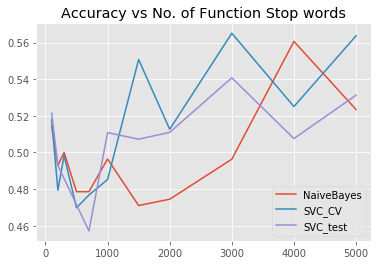

In [73]:
plt.plot(x, y_1, label = 'NaiveBayes')
plt.title('Accuracy vs No. of Function Stop words')
plt.plot(x, y_2, label = 'SVC_CV')
plt.plot(x, y_3, label = 'SVC_test')
plt.legend()
plt.show

# BUILDING A NEURAL NETWORK WITH KERAS

In [48]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y_label,test_size = 0.2)

In [49]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras import models
from keras import layers

Using TensorFlow backend.


In [598]:
# Create function returning a compiled network
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=50, activation='relu', input_shape=4449))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=10, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='sigmoid'))

    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer='rmsprop', # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
    
    # Return compiled network
    return network

In [51]:
# Neural network
model = Sequential()
model.add(Dense(50, input_dim=117556, activation='relu'))
model.add(Dense(10, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

W0725 15:42:21.850584 140106715858752 deprecation_wrapper.py:119] From /home/bilal/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 15:42:22.139853 140106715858752 deprecation_wrapper.py:119] From /home/bilal/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 15:42:22.163035 140106715858752 deprecation_wrapper.py:119] From /home/bilal/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [52]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W0725 15:42:25.960011 140106715858752 deprecation_wrapper.py:119] From /home/bilal/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 15:42:25.979724 140106715858752 deprecation_wrapper.py:119] From /home/bilal/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0725 15:42:25.983666 140106715858752 deprecation.py:323] From /home/bilal/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [53]:
history_ = model.fit(X_train, y_train, epochs=100, batch_size=64)

ValueError: Error when checking target: expected dense_3 to have shape (2,) but got array with shape (1,)

In [548]:
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [549]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 61.66666666666667


In [533]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=100, batch_size=64)

Train on 540 samples, validate on 60 samples
Epoch 1/100
540/540 [==============================] - 1s 2ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.0241 - val_acc: 0.6500
Epoch 2/100
540/540 [==============================] - 0s 116us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.0256 - val_acc: 0.6500
Epoch 3/100
540/540 [==============================] - 0s 122us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.0267 - val_acc: 0.6500
Epoch 4/100
540/540 [==============================] - 0s 104us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.0287 - val_acc: 0.6500
Epoch 5/100
540/540 [==============================] - 0s 115us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.0294 - val_acc: 0.6500
Epoch 6/100
540/540 [==============================] - 0s 116us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.0304 - val_acc: 0.6500
Epoch 7/100
540/540 [==============================] - 0s 105us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.0327 - val_acc: 0.6500
Epoch 8/100


Epoch 61/100
540/540 [==============================] - 0s 131us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.1155 - val_acc: 0.6333
Epoch 62/100
540/540 [==============================] - 0s 103us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.1155 - val_acc: 0.6333
Epoch 63/100
540/540 [==============================] - 0s 109us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.1170 - val_acc: 0.6333
Epoch 64/100
540/540 [==============================] - 0s 103us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 1.1189 - val_acc: 0.6333
Epoch 65/100
540/540 [==============================] - 0s 115us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.1180 - val_acc: 0.6333
Epoch 66/100
540/540 [==============================] - 0s 102us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.1190 - val_acc: 0.6333
Epoch 67/100
540/540 [==============================] - 0s 106us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.1214 - val_acc: 0.6333
Epoch 68/100
540/540 [==========================

In [605]:
from keras.wrappers.scikit_learn import KerasClassifier
neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=100, 
                                 batch_size=64)

cross_val_score(neural_network, X_train, y_train, cv=3)

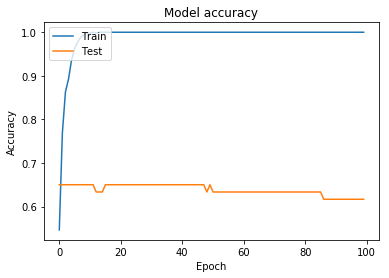

In [554]:
import matplotlib.pyplot as plt
plt.plot(history_.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

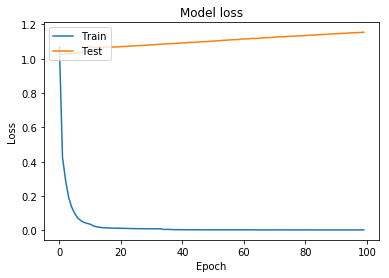

In [535]:
plt.plot(history_.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

# HYPER-PARAMTER TUNING USING PIPELINES

In [76]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [77]:
X_pos = text['POS_tags']
X_stopwords = text['CEO_stopwords']

In [78]:
from sklearn.model_selection import train_test_split

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_label, test_size=0.20,random_state=109)

X_train_stopwords, X_test_stopwords, y_train_stopwords, y_test_stopwords = train_test_split(X_stopwords, y_label, test_size=0.20,random_state=109)

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer())
])

In [80]:
tfidf_pipeline.fit_transform(X_train_pos)
tfidf_pipeline.fit_transform(X_train_stopwords)

<480x143 sparse matrix of type '<class 'numpy.float64'>'
	with 59242 stored elements in Compressed Sparse Row format>

In [81]:
tfidf_pipeline.fit_transform(X_test_pos)
tfidf_pipeline.fit_transform(X_test_stopwords)

<120x139 sparse matrix of type '<class 'numpy.float64'>'
	with 14747 stored elements in Compressed Sparse Row format>

In [82]:
from sklearn.svm import LinearSVC
svc_pipeline = Pipeline([
    ('tfidf_pip', tfidf_pipeline),
    ('svc', LinearSVC())
])

In [83]:
import math
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.svm import LinearSVC

In [84]:
grid_params_stopwords = {
    'tfidf_pip__tfidf_vectorizer__ngram_range' : [(1, 4)],
    'tfidf_pip__tfidf_vectorizer__max_features' : [int(x) for x in np.logspace(1, 4.694, 20)]
}

In [85]:
grid_params_pos = {
    'tfidf_pip__tfidf_vectorizer__ngram_range' : [(1, 4)],
    'tfidf_pip__tfidf_vectorizer__max_features' : [int(x) for x in np.logspace(1, 4.879, 20)]
    
}

# SVC HYPER-PARAMTER TUNING

In [88]:
%%time
from sklearn.model_selection import GridSearchCV



clf = GridSearchCV(svc_pipeline, grid_params_stopwords, scoring = 'accuracy', verbose=1, n_jobs=-1)
clf.fit(X_train_stopwords, y_train_stopwords)


print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 16.8min finished


Best Score:  0.5270833333333333
Best Params:  {'tfidf_pip__tfidf_vectorizer__max_features': 5271, 'tfidf_pip__tfidf_vectorizer__ngram_range': (1, 4)}
CPU times: user 1min 6s, sys: 3.64 s, total: 1min 9s
Wall time: 17min 53s


In [89]:
%%time
from sklearn.model_selection import GridSearchCV



clf = GridSearchCV(svc_pipeline, grid_params_pos, scoring = 'accuracy', verbose=1, n_jobs=-1)
clf.fit(X_train_pos, y_train_pos)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 20.5min finished
/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score:  0.5604166666666667
Best Params:  {'tfidf_pip__tfidf_vectorizer__max_features': 167, 'tfidf_pip__tfidf_vectorizer__ngram_range': (1, 4)}
CPU times: user 1min 22s, sys: 5.37 s, total: 1min 27s
Wall time: 21min 46s


# Random Forest Classifier

In [83]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier()
tree.fit(X, y_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [87]:
print(f'Model Accuracy: {tree.score(X, y_label)}')

Model Accuracy: 1.0


In [88]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [91]:
# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]

In [93]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)

In [94]:
roc_value

0.5805335968379447

In [95]:
import pandas as pd

# Extract feature importances
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
5011,will of_SP,0.002858
5348,v_pos,0.002661
4104,to and we are_SP,0.002355
3030,than and_SP,0.002169
4563,we about_SP,0.002159
